In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import keras.backend as K
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
from keras.models import Model
from keras.layers import Input,LSTM,Dense
import numpy as np 

In [4]:
batch_size = 64
epochs = 20
latent_dim = 256
num_samples = 10000
data_path = r'data/fra.txt'

In [5]:
#vectorize the data
input_texts = []
target_texts =[]
input_characters = set()
target_characters = set()
with open(data_path,'r',encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text , target_text = line.split('\t')
    #'\t' 作为start sequence '\n' 作为 end sequence
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    #建立词表vocab
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

#对vocab排了个序 没必要
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
#vocab size 
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

#文本最大长度
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [6]:
#字典映射 char - id 
input_token_index = dict([char ,i] for i,char in enumerate(input_characters))
target_token_index = dict([char,i] for i,char in enumerate(target_characters))

encoder_input_data = np.zeros((len(input_texts),max_encoder_seq_length,num_encoder_tokens),dtype = 'float32')
decoder_input_data = np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype = 'float32')
decoder_target_data = np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype = 'float32')

# emboding
for i ,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]] = 1 
    for t,char in enumerate(target_text):
        decoder_input_data[i,t,target_token_index[char]] = 1
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i,t-1,target_token_index[char]] = 1


In [35]:
#编码
encoder_inputs = Input(shape = (None,num_encoder_tokens))
encoder = LSTM(latent_dim,return_state=True)
encoder_outputs,state_h,state_c = encoder(encoder_inputs)
encoder_states = [state_h,state_c]

#解码
decoder_inputs = Input(shape=(None,num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,_,_ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens,activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.compile(optimizer ='adam',loss = 'categorical_crossentropy')
history = model.fit([encoder_input_data,decoder_input_data],decoder_target_data,
         batch_size = batch_size,
         shuffle = True,
         epochs = epochs,
         validation_split = 0.2)


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 28s 4ms/step - loss: 0.9563 - val_loss: 0.9717
Epoch 2/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.7666 - val_loss: 0.7993
Epoch 3/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.6424 - val_loss: 0.7014
Epoch 4/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.5810 - val_loss: 0.6483
Epoch 5/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.5434 - val_loss: 0.6200
Epoch 6/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.5154 - val_loss: 0.5898
Epoch 7/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4930 - val_loss: 0.5705
Epoch 8/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4737 - val_loss: 0.5531
Epoch 9/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4556 - val_loss: 0.5334
Epoch 10/10
8000/8000 [==

In [44]:
history = model.fit([encoder_input_data,decoder_input_data],decoder_target_data,
         batch_size = batch_size,
         epochs = epochs,
         shuffle = True,
         validation_split = 0.2)
model.save('s2.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.3567 - val_loss: 0.4533
Epoch 2/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.3476 - val_loss: 0.4527
Epoch 3/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3389 - val_loss: 0.4454
Epoch 4/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3305 - val_loss: 0.4442
Epoch 5/10
8000/8000 [==============================] - 23s 3ms/step - loss: 0.3227 - val_loss: 0.4398
Epoch 6/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3151 - val_loss: 0.4344
Epoch 7/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.3072 - val_loss: 0.4358
Epoch 8/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.3006 - val_loss: 0.4316
Epoch 9/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.2924 - val_loss: 0.4297
Epoch 10/10
8000/8000 [==

C:\Program Files\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_7/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_7/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [37]:
import matplotlib.pyplot as plt

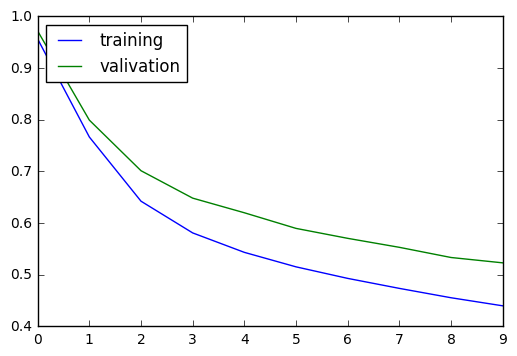

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','valivation'],loc='upper left')
plt.show()

In [39]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

In [45]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(decoder_inputs,initial_state=decoder_states_inputs)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

In [46]:
#id-char
reverse_input_char_id = dict((i,char) for char ,i in input_token_index.items())
reverse_target_char_index = dict((i,char) for char,i in target_token_index.items())


In [47]:
def decode_sequence(input_seq):
    # encode the input as state vectors
    states_value = encoder_model.predict(input_seq)
    
    #generate empty target sequence of length 1
    target_seq = np.zeros((1,1,num_decoder_tokens))
    target_seq[0,0,target_token_index['\t']] = 1 
    
    #sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        ouput_tokens,h,c = decoder_model.predict([target_seq] + states_value)
        
        #sample a token
        sampled_token_index = np.argmax(ouput_tokens[0,-1,:])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence +=sampled_char
        
        #exit condition :either hit max length or fild stop character
        if(sampled_char =='\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition  = True
        
        # update the target sequence 
        target_seq = np.zeros((1,1,num_decoder_tokens))
        target_seq[0,0,sampled_token_index] = 1
        #update states
        states_value = [h,c]
    return decoded_sentence
        
        

In [48]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoderd_sentence = decode_sequence(input_seq)
    print('-')
    print('input sentence:',input_texts[seq_index])
    print('decoded sentence:',decoderd_sentence)

-
input sentence: Go.
decoded sentence: Bonne chanter.

-
input sentence: Hi.
decoded sentence: Salut !

-
input sentence: Run!
decoded sentence: Prends un bon ter ?

-
input sentence: Run!
decoded sentence: Prends un bon ter ?

-
input sentence: Who?
decoded sentence: Qui vous ?

-
input sentence: Wow!
decoded sentence: Attends !

-
input sentence: Fire!
decoded sentence: At pleur ?

-
input sentence: Help!
decoded sentence: Sellez-vous !

-
input sentence: Jump.
decoded sentence: Venez vous prête !

-
input sentence: Stop!
decoded sentence: Arrête de te plaît.

-
input sentence: Stop!
decoded sentence: Arrête de te plaît.

-
input sentence: Stop!
decoded sentence: Arrête de te plaît.

-
input sentence: Wait!
decoded sentence: Attends !

-
input sentence: Wait!
decoded sentence: Attends !

-
input sentence: Go on.
decoded sentence: Va chercher !

-
input sentence: Go on.
decoded sentence: Va chercher !

-
input sentence: Go on.
decoded sentence: Va chercher !

-
input sentence: Hello!